In [1]:
import pandas as pd
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline

In [2]:
year = 2007
path = f"C:/Users/Redata/Downloads/read/kemiskinan/hh{year}/"


In [3]:
#respndnt in 2007 and rspndnt in 2014
cov = pd.read_stata(path + "b3a_cov.dta")[["sex", "respndnt", "age", "marstat", "pidlink"]]

# our interest just people in youth age (15-24 covd on ILO standard) and not as Head of household or the spoise
cov["respndnt"] = cov["respndnt"].astype("str").str.extract(r'(\d+)')[0]
z = cov[(cov["age"] < 25) & (cov.respndnt == "3")]

In [4]:
hh = pd.read_stata(path +"ptrack.dta")[["ar02b_07", "hhid07", "pid07", "hhid00", "pid00", "pidlink"]]
x = pd.merge(z, hh, left_on="pidlink", right_on= "pidlink", how="left")


x["ar02b_07"] = x["ar02b_07"].astype("str").str.extract(r'(\d+)')[0].fillna("0")

# make sure that just the 'children' relation to head of household; Children,Grandchild,Nephews/nieces, Cousins
# Wife/husband, Siblings, Servants, Brother/sister-in-law, Sons/daughters-in-law, Uncles/aunts, Non-relative, all exclude
base = x[(x["ar02b_07"] == "3") | (x["ar02b_07"] == "4") 
               | (x["ar02b_07"] == "10") | (x["ar02b_07"] == "13") | (x["ar02b_07"] == "14") ]
base.shape

(4678, 10)

## Dependent variable

In [5]:
b = pd.read_stata(path + "b3a_tk1.dta")
c = pd.read_stata(path + "b3a_tk2.dta")
a = pd.merge(b, c, left_on="pidlink", right_on="pidlink", how="left")
a.sample(3)

,hhid07_9_x,pid07_x,tk01a,tk01b,tk01c,tk01d,tk01,tk02,tk03,tk04,...,tk23b2mx,tk23b2yx,tk20ba,tk25b1,tk25b2,tk25b2b,tk26b1,tk26b3,version_y,module_y
22345,255081100,2.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,...,,,NaN,NaN,NaN,NaN,NaN,NaN,1.0,B3A_TK2
28144,312180000,2.0,1.0,3.0,1.0,3.0,1.0,NaN,NaN,NaN,...,3,1,0.0,NaN,NaN,NaN,90000.0,1000000.0,1.0,B3A_TK2
15880,182070000,4.0,3.0,3.0,1.0,3.0,4.0,3.0,1.0,NaN,...,.,.,NaN,NaN,NaN,NaN,NaN,NaN,1.0,B3A_TK2


In [6]:
a["tk25a9x"] = a["tk25a9x"].astype("str").str.extract(r'(\d+)')[0].apply(lambda x: 1 if x in ["2", "1"] else 0)

In [7]:
tk = ["tk02","tk03","tk04","tk01a","tk01b", "tk01c", "tk01d", "tk16d", "tk16i"]
for i in tk:
    a[i] = a[i].astype("str").str.extract(r'(\d+)')[0].apply(lambda x: 0 if x != "1" else 1)

In [8]:
lis_a = tk + ["pidlink", "tk01", "tk25a9x", "tk16h"]
a["tk01"] = a["tk01"].astype("str").str.extract(r'(\d+)')[0].fillna("99").astype("int")
a = a[lis_a].query('(tk01 != 9) & (tk01 != 99)')

### Define NEET variabel

In [9]:
def neet(data):
    if data in [1,3]:
        return 1
    else:
        return 0

In [10]:
a["main"] = a["tk01"].apply(lambda x: neet(x))

In [11]:
#based on a strict list of activity ever do in last week AND main activity-
a["NEET"] = a[["main", "tk02",
                        "tk03","tk04","tk01a","tk01b", "tk25a9x"]].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
a["NEET( just other)"] = (a["NEET"] + a["tk01"]).apply(lambda x: 0 if x != 96 else 1)

In [12]:
df = pd.merge(base, a, left_on="pidlink", right_on="pidlink", how="inner")
df.shape

(4514, 25)

In [13]:
#crosscheck
pd.crosstab(df["NEET"], df["tk02"])

tk02,0,1
NEET,,
0,3209,363
1,942,0


In [14]:
df["year"] = year

In [15]:
#storing data
df.to_stata(f"dataneetpertama{year}.dta")

df.head(10)

,sex,respndnt,age,marstat,pidlink,ar02b_07,hhid07,pid07,hhid00,pid00,...,tk01d,tk16d,tk16i,tk01,tk25a9x,tk16h,main,NEET,NEET( just other),year
0,1.0,3,22.0,1.0,001220006,3,0012200,6.0,0012200,6.0,...,0,0,0,1,1,2.0,1,0,0,2007
1,3.0,3,20.0,1.0,001220007,3,0012200,7.0,0012200,7.0,...,0,0,0,1,0,1.0,1,0,0,2007
2,1.0,3,15.0,1.0,001220009,3,0012200,9.0,0012200,9.0,...,0,0,0,3,0,3.0,1,0,0,2007
3,3.0,3,17.0,1.0,002040004,13,0020442,3.0,0020400,4.0,...,0,0,0,3,0,3.0,1,0,0,2007
4,1.0,3,17.0,1.0,002110005,3,0021100,5.0,0021100,5.0,...,0,0,0,3,0,95.0,1,0,0,2007
5,1.0,3,19.0,2.0,002180006,3,0021800,6.0,0021800,6.0,...,0,0,1,1,0,1.0,1,0,0,2007
6,3.0,3,15.0,1.0,002180008,3,0021800,8.0,0021800,8.0,...,0,0,0,3,0,3.0,1,0,0,2007
7,1.0,3,20.0,2.0,002184101,3,0021841,1.0,0021841,NaN,...,0,0,0,4,0,95.0,0,1,0,2007
8,3.0,3,15.0,1.0,002190004,3,0021900,4.0,0021900,NaN,...,0,0,0,4,0,1.0,0,0,0,2007
9,1.0,3,21.0,1.0,002250004,3,0022500,4.0,0022500,4.0,...,1,1,1,1,1,NaN,1,0,0,2007


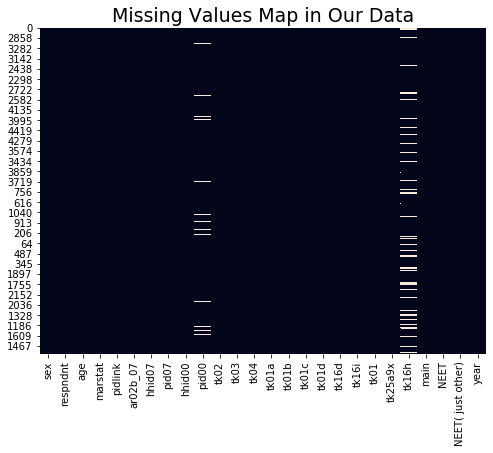

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull().sort_values("tk02"), cbar=False)
plt.title("Missing Values Map in Our Data", size=19);